In [1]:
%run ./PPS_Expansion_Model.ipynb

/home/renato-paredes/.virtualenvs/gifted/lib/python3.13/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


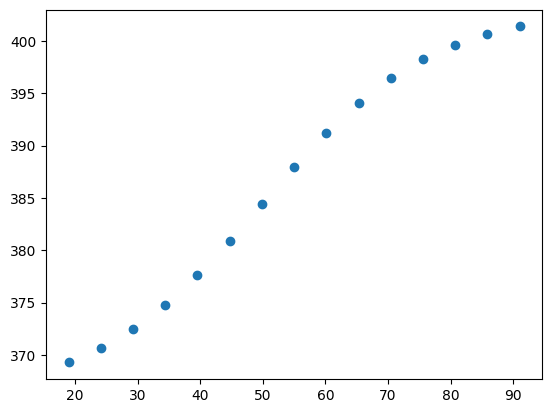

In [2]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
s_distances_sec = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
a_distances = 100 - s_distances_sec * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

##Pre-Training
###SCZ
ymin = 366
ymax = 403
scz_cp = 100 - 1.666 * 30
scz_slope = 1 / 0.075

SCZ_RTs = RTsig(a_distances, scz_cp, scz_slope)
plt.scatter(a_distances, SCZ_RTs)

In [3]:
from scipy.optimize import differential_evolution

HCWat, HCWvt, HCWav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=1.289e01,
    k2=7.552e02,
    lim=3.674e01,
    alpha=9.797e-01,
)

SCZLt, SCZLa, SCZLv = Lw(
    Lex_t=0.15,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=0.15,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=0.15,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)


def sczmodelrun(theta):
    _, _, _, _, SCZrt = experiment(
        ts=ts,
        T=simtime,
        dist=a_distances,
        ya=5,
        Lt=SCZLt,
        La=SCZLa,
        Lv=SCZLv,
        Wt=HCWt,
        Wa=HCWa,
        Wv=HCWv,
        Bt=HCBt,
        Ba=HCBa,
        Bv=HCBv,
        Wat=HCWat,
        Wvt=HCWvt,
        Wav=HCWav,
        FWpr=theta[0],
        CMpr=0,
    )

    SCZ_Model_RTs = fit_RT(xf=SCZrt, yf=SCZ_RTs)
    cost = np.sum(np.square(np.divide(SCZ_RTs - (SCZ_Model_RTs), SCZ_RTs)))

    return cost * 100000


bounds = [(0, 6.5)]
sczres = differential_evolution(
    sczmodelrun, bounds, disp=True, workers=30, updating="deferred", polish=False
)

differential_evolution step 1: f(x)= 50.693906695015684
differential_evolution step 2: f(x)= 50.693906695015684
differential_evolution step 3: f(x)= 50.693906695015684
differential_evolution step 4: f(x)= 50.693906695015684
differential_evolution step 5: f(x)= 50.693906695015684
differential_evolution step 6: f(x)= 50.693906695015684
differential_evolution step 7: f(x)= 50.693906695015684
differential_evolution step 8: f(x)= 50.693906695015684
differential_evolution step 9: f(x)= 50.693906695015684
differential_evolution step 10: f(x)= 50.693906695015684


In [5]:
print(sczres)

             message: Optimization terminated successfully.
             success: True
                 fun: 50.693906695015684
                   x: [ 6.049e-02]
                 nit: 10
                nfev: 165
          population: [[ 6.049e-02]
                       [ 3.856e-02]
                       ...
                       [ 6.106e-02]
                       [ 7.691e-02]]
 population_energies: [ 5.069e+01  5.069e+01 ...  5.069e+01  5.069e+01]


In [6]:
## Fitted model

Pr = 6.049e-02

SCZLt, SCZLa, SCZLv = Lw(
    Lex_t=0.15,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=0.15,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=0.15,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)
HCWat, HCWvt, HCWav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=1.289e01,
    k2=7.552e02,
    lim=3.674e01,
    alpha=9.797e-01,
)

_, _, _, _, SCZ_Model_RTs = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=Pr,
    CMpr=0,
)

SCZ_Model_RTs_scaled = fit_RT(xf=SCZ_Model_RTs, yf=SCZ_RTs)

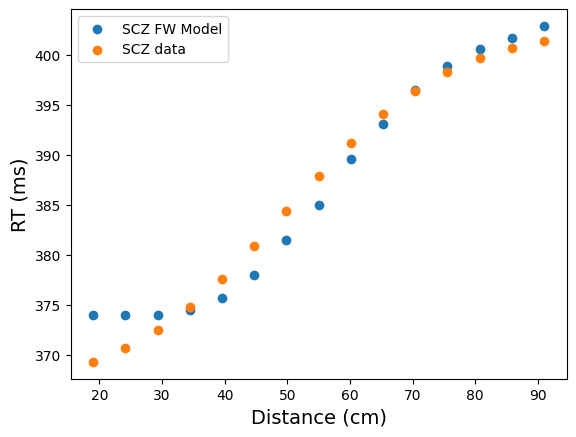

In [10]:
plt.scatter(a_distances, SCZ_Model_RTs_scaled, label="SCZ FW Model")
plt.scatter(a_distances, SCZ_RTs, label="SCZ data")
plt.ylabel("RT (ms)", size=14)
plt.xlabel("Distance (cm)", size=14)
plt.legend(prop={"size": 12})
plt.legend()

In [9]:
scz_error = calculate_adj_rmse(SCZ_Model_RTs_scaled, SCZ_RTs, 3)
print(scz_error)

2.458357492973899
